<a href="https://colab.research.google.com/github/ShotaSasaki-HU/ASTRO-CAMP-2025/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリ

In [ ]:
!pip install earthengine-api geemap rasterio folium scikit-learn --quiet
!pip install rasterio
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ee
import geemap
import geopandas as gpd
from shapely.geometry import box
import datetime
!pip install japanize-matplotlib
import japanize_matplotlib

# GEEの認証

In [ ]:
ee.Authenticate() # Colabではブラウザで認証を行う
#ee.Initialize(project='astro-camp')
ee.Initialize(project='my-project-astrocamp')

# 目的変数

## 被害率（正解データ）のdf_damage_ratio
年度ごとに形式が異なる．

In [ ]:
prefectures = ["福岡", "佐賀", "長崎", "大分", "熊本", "宮崎", "鹿児島"]

# 初期データフレーム
cols = ["都道府県", "year", "被害面積（ha）", "被害量（t）", "被害率（%）"]
df_damage_ratio = pd.DataFrame(columns=cols)

for prefecture in prefectures:
    # 2016
    year = 2016
    path_csv = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89/{year}_%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89.csv"
    df = pd.read_csv(path_csv, encoding="shift-jis", header=0)

    target_col = [col for col in df.columns if "全国農業地域" in col][0] # 「全国農業地域」を含む列名を抽出
    df = df[df[target_col].str.contains(prefecture)]

    target_col = [col for col in df.columns if "項目" in col][0]
    df_damaged_area = df[df[target_col] == "虫害_ウンカ_被害面積"]
    df_damaged_amount = df[df[target_col] == "虫害_ウンカ_被害量"]
    df_damaged_ratio = df[df[target_col] == "虫害_ウンカ_被害率"]

    df_damage_ratio.loc[len(df_damage_ratio)] = [
        prefecture,
        year,
        float(df_damaged_area["value"].iloc[0]),
        float(df_damaged_amount["value"].iloc[0]),
        float(df_damaged_ratio["value"].iloc[0])
        ]

    # 2017
    year = 2017
    path_csv = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89/{year}_%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89.csv"
    df = pd.read_csv(path_csv, encoding="shift-jis", header=0)

    target_col = [col for col in df.columns if "全国農業地域" in col][0] # 「全国農業地域」を含む列名を抽出
    df = df[df[target_col].str.contains(prefecture)]

    df = df[df["平成29水稲被害面積被害量"] == "虫害_ウンカ"]
    df_damaged_area = df[df["平成29水稲被害率被害量"] == "被害面積"]
    df_damaged_amount = df[df["平成29水稲被害率被害量"] == "被害量"]
    df_damaged_ratio = df[df["平成29水稲被害率被害量"] == "被害率_実数"]

    df_damage_ratio.loc[len(df_damage_ratio)] = [
        prefecture,
        year,
        float(df_damaged_area["value"].iloc[0]),
        float(df_damaged_amount["value"].iloc[0]),
        float(df_damaged_ratio["value"].iloc[0])
        ]

    # 2018
    year = 2018
    path_csv = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89/{year}_%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89.csv"
    df = pd.read_csv(path_csv, encoding="shift-jis", header=0)

    target_col = [col for col in df.columns if "全国農業地域" in col][0] # 「全国農業地域」を含む列名を抽出
    df = df[df[target_col].str.contains(prefecture)]

    df = df[df["(F002-30-1-012)被害量"] == "虫害_ウンカ"]
    df_damaged_area = df[df["(F002-30-1-011)被害項目"] == "被害面積"]
    df_damaged_amount = df[df["(F002-30-1-011)被害項目"] == "被害量"]
    df_damaged_ratio = df[df["(F002-30-1-011)被害項目"] == "被害率_実数"]

    df_damage_ratio.loc[len(df_damage_ratio)] = [
        prefecture,
        year,
        float(df_damaged_area["value"].iloc[0]),
        float(df_damaged_amount["value"].iloc[0]),
        float(df_damaged_ratio["value"].iloc[0])
        ]

    # 2019
    year = 2019
    path_csv = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89/{year}_%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89.csv"
    df = pd.read_csv(path_csv, encoding="shift-jis", header=0)

    target_col = [col for col in df.columns if "全国農業地域" in col][0] # 「全国農業地域」を含む列名を抽出
    df = df[df[target_col].str.contains(prefecture)]

    df = df[df["被害原因"] == "虫害_ウンカ"]
    df_damaged_area = df[df["表章項目"] == "被害面積"]
    df_damaged_amount = df[df["表章項目"] == "被害量"]
    df_damaged_ratio = df[df["表章項目"] == "被害率_実数"]

    df_damage_ratio.loc[len(df_damage_ratio)] = [
        prefecture,
        year,
        float(df_damaged_area["value"].iloc[0]),
        float(df_damaged_amount["value"].iloc[0]),
        float(df_damaged_ratio["value"].iloc[0])
        ]

    # 2020 ~ 2023
    for year in range(2020, 2023+1):
        path_csv = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89/{year}_%E6%B0%B4%E7%A8%B2%E3%81%AE%E8%A2%AB%E5%AE%B3%E9%9D%A2%E7%A9%8D%E5%8F%8A%E3%81%B2%E3%82%99%E8%A2%AB%E5%AE%B3%E9%87%8F%EF%BC%88%E5%85%A8%E5%9B%BD%E8%BE%B2%E6%A5%AD%E5%9C%B0%E5%9F%9F%E5%88%A5%E3%83%BB%E9%83%BD%E9%81%93%E5%BA%9C%E7%9C%8C%E5%88%A5%EF%BC%89.csv"
        df = pd.read_csv(path_csv, encoding="shift-jis", header=0)

        target_col = [col for col in df.columns if "全国農業地域" in col][0] # 「全国農業地域」を含む列名を抽出
        df = df[df[target_col].str.contains(prefecture)]

        target_col = [col for col in df.columns if "被害面積及び被害量" in col][0]
        df_damaged_area = df[df[target_col] == "虫害_ウンカ_被害面積"]
        df_damaged_amount = df[df[target_col] == "虫害_ウンカ_被害量"]
        df_damaged_ratio = df[df[target_col] == "虫害_ウンカ_被害率_実数"]

        df_damage_ratio.loc[len(df_damage_ratio)] = [
            prefecture,
            year,
            float(df_damaged_area["value"].iloc[0]),
            float(df_damaged_amount["value"].iloc[0]),
            float(df_damaged_ratio["value"].iloc[0])
            ]

print(df_damage_ratio)


   都道府県  year  被害面積（ha）  被害量（t）  被害率（%）
0    福岡  2016    1280.0   182.0     0.1
1    福岡  2017    3010.0   495.0     0.3
2    福岡  2018    1120.0   121.0     0.1
3    福岡  2019    7060.0  2210.0     1.3
4    福岡  2020    9690.0  2890.0     1.7
5    福岡  2021     785.0   132.0     0.1
6    福岡  2022     686.0   203.0     0.1
7    福岡  2023     540.0    54.0     0.0
8    佐賀  2016    3140.0  1920.0     1.5
9    佐賀  2017    5550.0  2320.0     1.8
10   佐賀  2018     474.0    38.0     0.0
11   佐賀  2019    7630.0  6790.0     5.4
12   佐賀  2020    1470.0  1520.0     1.2
13   佐賀  2021     467.0   108.0     0.1
14   佐賀  2022     616.0   407.0     0.3
15   佐賀  2023      96.0    42.0     0.0
16   長崎  2016    1230.0   653.0     1.1
17   長崎  2017    2090.0   818.0     1.5
18   長崎  2018     539.0    33.0     0.1
19   長崎  2019    2980.0  1790.0     3.3
20   長崎  2020    2380.0  1540.0     2.9
21   長崎  2021     506.0    98.0     0.2
22   長崎  2022     606.0    91.0     0.2
23   長崎  2023     594.0   106.0     0.2


# 説明変数

## NDVIのdf_ndvi

In [ ]:
trio_per_year = {
    2016: ["2016-03-28", "2016-04-30", "2016-06-16"],
    2017: ["2017-04-02", "2017-05-05", "2017-07-14"],
    2018: ["2018-03-28", "2018-04-25", "2018-06-16"],
    2019: ["2019-04-07", "2019-05-10", "2019-06-14"],
    2020: ["2020-04-16", "2020-05-19", "2020-06-15"],
    2021: ["2021-04-09", "2021-05-14", "2021-06-05"],
    2022: ["2022-04-11", "2022-05-16", "2022-06-25"],
    2023: ["2023-04-11", "2023-05-09", "2023-06-10"],
    2024: ["2024-03-29", "2024-05-08", "2024-05-28"],
    2025: ["2025-04-15", "2025-05-13", "2025-06-17"]
}

# 初期データフレーム
cols = ["year", "NDVI_4月", "NDVI_5月", "NDVI_6月"]
df_ndvi = pd.DataFrame(columns=cols)

for year in trio_per_year.keys():
    trio = trio_per_year[year]

    ndvi_means = []
    for date in trio:
        file_path = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/Sentinel-2_L2A/Jiangxi/{date}.tif"

        # GeoTIFFを開く
        with rasterio.open(file_path) as src:
            # バンド数
            # print(f"バンド数: {src.count}")
            # サイズ
            # print(f"width: {src.width}, height: {src.height}")
            # 緯度経度の情報
            # print(src.crs)
            # print(src.descriptions)

            blue = src.read(4, masked=True)
            green = src.read(3, masked=True)
            red = src.read(2, masked=True)
            nir = src.read(1, masked=True)
            scl = src.read(5, masked=True)

        # NDVIを計算（浮動小数点にキャスト）
        red = red.astype(np.float32)
        nir = nir.astype(np.float32)
        ndvi = (nir - red) / (nir + red + 1e-6) # 0除算対策あり

        # sclの値が3, 8, 9のいずれかであるかを示すマスクを作成
        # np.isin()は、sclの各要素がリスト内の値と一致するかを調べる
        cloud_values = [3, 8, 9]
        cloud_mask = np.isin(scl, cloud_values)

        # clear_mask は cloud_mask の反対 (雲でない場所がTrue)
        clear_mask = ~cloud_mask

        # clear_maskを使ってNDVIから雲に該当するピクセルを除外（NaNにする）
        ndvi = np.where(clear_mask == 1, ndvi, np.nan)

        ndvi_means.append(np.nanmean(ndvi))

    df_ndvi.loc[len(df_ndvi)] = [
        year,
        ndvi_means[0],
        ndvi_means[1],
        ndvi_means[2]
    ]

print(df_ndvi)


     year   NDVI_4月   NDVI_5月   NDVI_6月
0  2016.0  0.260767  0.247656  0.582581
1  2017.0  0.278274  0.323985  0.553824
2  2018.0  0.275512  0.244884  0.649558
3  2019.0  0.351347  0.319044  0.570337
4  2020.0  0.257404  0.477649  0.658018
5  2021.0  0.379738  0.342842  0.582020
6  2022.0  0.295045  0.430258  0.620685
7  2023.0  0.213523  0.320940  0.674726
8  2024.0  0.166031  0.349492  0.688019
9  2025.0  0.240710  0.466370  0.798590


##降水量のdf_precip_wide


In [ ]:


# ウンカ発生地域（中国南部の矩形）
region = ee.Geometry.Rectangle([100, 15, 115, 30])

# ★ここを差し替え：ERA5→ERA5-Land の月別アグリ
era5_land = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
    .select("total_precipitation_sum")  # 月合計（m）

years  = list(range(2016, 2026))  # 2016〜2025
months = [4, 5, 6]                 # 4,5,6月

records = []

for y in years:
    for m in months:
        # 年月で安全にフィルタ（calendarRangeが堅い）
        coll = (era5_land
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month')))

        if coll.size().getInfo() == 0:
            print(f"[WARN] No image for {y}-{m:02d}")
            continue

        img = ee.Image(coll.first())

        # 指定矩形で平均（=領域平均の月合計降水量[m]）
        v_m = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000,    # 約10km
            maxPixels=1e13
        ).get("total_precipitation_sum").getInfo()

        records.append({
            "year": y,
            "month": m,
            "降水量(mm)": None if v_m is None else float(v_m) * 1000.0  # m→mm
        })

df_precip = pd.DataFrame(records).sort_values(["year","month"]).reset_index(drop=True)


# 必要なら横持ちに
df_precip_wide = (df_precip
                  .pivot_table(index="year", columns="month", values="降水量(mm)")
                  .rename(columns={4:"降水量_4月(mm)", 5:"降水量_5月(mm)", 6:"降水量_6月(mm)"})
                  .reset_index())
print(df_precip_wide)

# CSV保存（任意）
df_precip.to_csv("china_south_precip_2016_2025.csv", index=False)
df_precip_wide.to_csv("china_south_precip_2016_2025_wide.csv", index=False)


month  year  降水量_4月(mm)  降水量_5月(mm)  降水量_6月(mm)
0      2016  170.046585  225.714265  257.054110
1      2017  114.864952  182.642943  298.798780
2      2018  122.508184  189.495437  259.153775
3      2019  132.426619  191.816427  235.219890
4      2020  112.915975  163.219869  239.516606
5      2021  151.458564  193.342925  228.161303
6      2022  127.669783  266.976040  258.843356
7      2023  115.186842  144.495465  237.064695
8      2024  176.705156  232.024217  318.229076
9      2025  109.398454  240.357246  293.511007


## 地表面温度のdf_temp

In [ ]:
# 1. 定数を設定
# 分析対象領域 (Area of Interest)
region = ee.Geometry.Rectangle([116.14615, 28.91031, 116.16521, 28.92906])
# 対象とする年と月
start_year = 2016
end_year = 2024
months = [4, 5, 6]
# ウンカの発育下限温度（基準温度）。文献等を参考に設定するのが望ましい。
base_temperature = 12.0 # 佐賀のパラメータを参照

# 2. 結果を格納するための空のリストを準備
all_results = []

# 3. 年と月でループ処理
print(f"積算温度（基準温度: {base_temperature}°C）の計算を開始します...")
for year in range(start_year, end_year + 1):

    yearly_data = {'year': year}

    for month in months:
        # 月の開始日と終了日を定義
        start_date = f'{year}-{month:02d}-01'
        ee_start_date = ee.Date(start_date)
        ee_end_date = ee_start_date.advance(1, 'month')
        end_date = ee_end_date.format('YYYY-MM-dd').getInfo()

        # その月の日数を取得
        days_in_month = ee_end_date.difference(ee_start_date, 'day')

        # 指定した月のMODIS画像コレクションを取得
        collection = ee.ImageCollection('MODIS/061/MOD11A1').filterDate(start_date, end_date)

        # --- ここからが積算温度の計算部分 ---

        # 日々の積算温度を計算する関数を定義
        def calculate_degree_days(image):
            # LSTバンドを選択し、スケール変換と単位変換（ケルビン -> 摂氏）
            temp_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15)
            # (毎日の気温 - 基準温度) を計算。結果がマイナスなら0にする。
            degree_day = temp_celsius.subtract(base_temperature).max(0)
            return degree_day

        # コレクション内の各画像（各日）に対して上記の関数を適用
        daily_degree_days = collection.map(calculate_degree_days)

        # 月間の「日平均」積算温度を計算し、その月の日数を掛けて正規化する
        monthly_degree_days_image = daily_degree_days.mean().multiply(days_in_month).rename('Degree_Days')

        # AOI内の平均値を計算
        stats = monthly_degree_days_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=1000,
            maxPixels=1e9
        ).getInfo()

        degree_days_value = stats.get('Degree_Days')

        column_name = f'積算温度_{month}月'
        yearly_data[column_name] = degree_days_value

    all_results.append(yearly_data)
    print(f"{year}年の処理が完了しました。")

# 4. リストからpandasデータフレームを作成
df_degree_days = pd.DataFrame(all_results)

print("\n--- 完成したデータフレーム ---")
print(df_degree_days)


積算温度（基準温度: 12.0°C）の計算を開始します...
2016年の処理が完了しました。
2017年の処理が完了しました。
2018年の処理が完了しました。
2019年の処理が完了しました。
2020年の処理が完了しました。
2021年の処理が完了しました。
2022年の処理が完了しました。
2023年の処理が完了しました。
2024年の処理が完了しました。

--- 完成したデータフレーム ---
   year     積算温度_4月     積算温度_5月     積算温度_6月
0  2016  402.662723  397.223200  467.851227
1  2017  362.130846  481.375167  505.144241
2  2018  364.371542  468.048532  513.777191
3  2019  368.138837  499.331053  483.312266
4  2020  344.669787  489.112161  470.968534
5  2021  353.458290  480.276688  524.483695
6  2022  398.732604  433.079071  437.893848
7  2023  359.636621  456.452175  505.404921
8  2024  417.800175  451.677709  203.100000


##散布ポテンシャルのdf_spray

In [ ]:
import pandas as pd

# GitHub上のCSVのURL
url = "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/CN_South_SprayPotential_AprJun_2016_2025_RegionMean.csv"

# 散布ポテンシャルのCSVを直接読み込み
df_spray = pd.read_csv(url, encoding="utf-8-sig")

# 不要列を削除
df_spray = df_spray.drop(columns=[c for c in df_spray.columns if "geo" in c.lower() or "system:index" in c], errors="ignore")

# 年・月を整数に
df_spray["year"] = df_spray["year"].astype(int)
df_spray["month"] = df_spray["month"].astype(int)
df_spray["spray_hours_mean"] = pd.to_numeric(df_spray["spray_hours_mean"], errors="coerce")

# ピボットして year を行、month を列にする
df_spray_wide = df_spray.pivot(index="year", columns="month", values="spray_hours_mean")

# 列名を分かりやすく変更
df_spray_wide = df_spray_wide.rename(columns={
    4: "散布ポテンシャル_4月",
    5: "散布ポテンシャル_5月",
    6: "散布ポテンシャル_6月"
})

# インデックスをカラムに戻す
df_spray_wide = df_spray_wide.reset_index()

print("--- 散布ポテンシャル（完成版） ---")
print(df_spray_wide)


--- 散布ポテンシャル（完成版） ---
month  year  散布ポテンシャル_4月  散布ポテンシャル_5月  散布ポテンシャル_6月
0      2016    41.695988    28.352339    19.505120
1      2017    38.316576    25.691756    14.960589
2      2018    38.834715    20.054588    18.286170
3      2019    35.375353    24.899986    21.804684
4      2020    41.880801    37.317308    18.092859
5      2021    25.774495    27.412390    25.471003
6      2022    41.609852    21.154982    21.305842
7      2023    43.825247    34.703736    20.546147
8      2024    48.131037    24.079765    17.807329
9      2025    41.372220    24.191954    16.910474


# dfへの統合

In [ ]:
# 正解データdf_damage_ratioをベースにする．
df = df_damage_ratio.copy() # 値渡し
df.drop(["被害面積（ha）", "被害量（t）"], axis=1, inplace=True)

# yearをキーにdf_ndviとdf_tempをマージ（左側優先）
df = df.merge(df_ndvi, on="year", how="left")
df = df.merge(df_degree_days, on="year", how="left")
df = df.merge(df_precip_wide, on="year", how="left")
df = df.merge(df_spray_wide, on="year", how="left")

# 不要な列を削除
df.drop(["都道府県"], axis=1, inplace=True)

df.dropna(inplace=True)
df.reset_index()
print("データ数:", len(df))
df


データ数: 56


,year,被害率（%）,NDVI_4月,NDVI_5月,NDVI_6月,積算温度_4月,積算温度_5月,積算温度_6月,降水量_4月(mm),降水量_5月(mm),降水量_6月(mm),散布ポテンシャル_4月,散布ポテンシャル_5月,散布ポテンシャル_6月
0,2016,0.1,0.260767,0.247656,0.582581,402.662723,397.223200,467.851227,170.046585,225.714265,257.054110,41.695988,28.352339,19.505120
1,2017,0.3,0.278274,0.323985,0.553824,362.130846,481.375167,505.144241,114.864952,182.642943,298.798780,38.316576,25.691756,14.960589
2,2018,0.1,0.275512,0.244884,0.649558,364.371542,468.048532,513.777191,122.508184,189.495437,259.153775,38.834715,20.054588,18.286170
3,2019,1.3,0.351347,0.319044,0.570337,368.138837,499.331053,483.312266,132.426619,191.816427,235.219890,35.375353,24.899986,21.804684
4,2020,1.7,0.257404,0.477649,0.658018,344.669787,489.112161,470.968534,112.915975,163.219869,239.516606,41.880801,37.317308,18.092859
5,2021,0.1,0.379738,0.342842,0.582020,353.458290,480.276688,524.483695,151.458564,193.342925,228.161303,25.774495,27.412390,25.471003
6,2022,0.1,0.295045,0.430258,0.620685,398.732604,433.079071,437.893848,127.669783,266.976040,258.843356,41.609852,21.154982,21.305842
7,2023,0.0,0.213523,0.320940,0.674726,359.636621,456.452175,505.404921,115.186842,144.495465,237.064695,43.825247,34.703736,20.546147
8,2016,1.5,0.260767,0.247656,0.582581,402.662723,397.223200,467.851227,170.046585,225.714265,257.054110,41.695988,28.352339,19.505120
9,2017,1.8,0.278274,0.323985,0.553824,362.130846,481.375167,505.144241,114.864952,182.642943,298.798780,38.316576,25.691756,14.960589


# 線形重回帰の実施

In [ ]:
# 説明変数と目的変数を選択
X = df[["NDVI_4月", "NDVI_5月", "NDVI_6月", "積算温度_4月", "積算温度_5月", "積算温度_6月","降水量_4月(mm)", "降水量_5月(mm)", "降水量_6月(mm)","散布ポテンシャル_4月","散布ポテンシャル_5月","散布ポテンシャル_6月"]].values
y = df["被害率（%）"].values # MODIS LST を目的変数にする例

# 学習/検証分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("係数:", model.coef_)
print("切片:", model.intercept_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


係数: [-0.00036041 -0.00161206  0.00063346 -0.01277666  0.04192257 -0.05491319
  0.07363164 -0.03507056  0.01113367  0.06870146 -0.08378743 -0.07100517]
切片: 8.77251590398403
MSE: 0.8294201388888892
R^2: 0.6941525185014468


# 分析

## 散布図（実測 vs 予測）

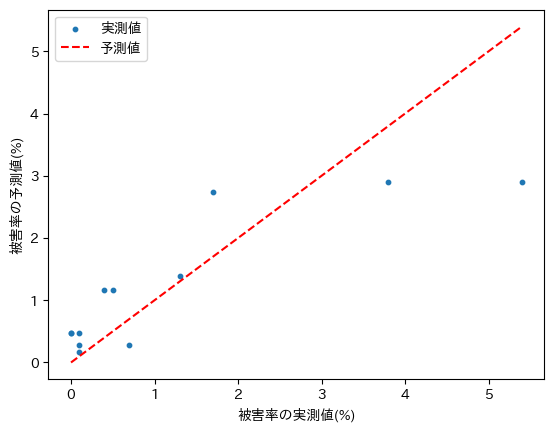

In [ ]:
# 散布図（実測 vs 予測）
plt.scatter(y_test, y_pred, s=10)
plt.xlabel("被害率の実測値(%)")
plt.ylabel("被害率の予測値(%)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(["実測値", "予測値"])
plt.show()


## 単一の説明変数について

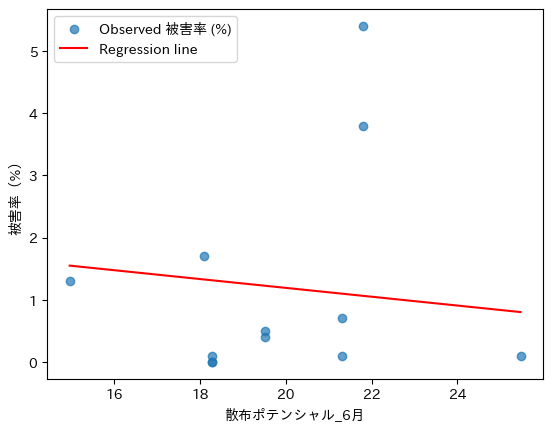

In [ ]:
# 横軸にする説明変数を選択
x_axis_var_index = 11# 0 ~ 5
index_to_label = {
    0: "NDVI_4月",
    1: "NDVI_5月",
    2: "NDVI_6月",
    3: "積算温度_4月",
    4: "積算温度_5月",
    5: "積算温度_6月",
    6: "降水量_4月",
    7: "降水量_5月",
    8: "降水量_6月",
    9: "散布ポテンシャル_4月",
    10: "散布ポテンシャル_5月",
    11: "散布ポテンシャル_6月"
}


# 実測値（y_test）を散布図に
plt.scatter(X_test[:, x_axis_var_index], y_test, label="Observed 被害率 (%)", alpha=0.7)

# 他の変数は平均値で固定して、回帰直線を作る
x_var_range = np.linspace(X_test[:, x_axis_var_index].min(),
                          X_test[:, x_axis_var_index].max(), 100)

X_fixed = np.zeros((100, X_test.shape[1]))
X_fixed[:, x_axis_var_index] = x_var_range

# 他の変数に平均値をセット
for i in range(X_test.shape[1]):
    if i != x_axis_var_index:
        X_fixed[:, i] = X_test[:, i].mean()

# モデルで予測
y_line = model.predict(X_fixed)

# 予測直線を描画
plt.plot(x_var_range, y_line, color="red", label="Regression line")

plt.xlabel(index_to_label[x_axis_var_index]) # 横軸名（選んだ変数に合わせて変更）
plt.ylabel("被害率（%）")
plt.legend()
plt.show()
